# Analysis for objective function 4 : fraction above threshold

This notebook contains the analyses for the fourth objective function. This fourth objective functios is a satisfycing metric of robustness. 


$$
\begin{equation}
    \begin{aligned}
    & \text{Minimize} && F(l_{p,r}) = (f_{damages}, f_{casualties}, f_{costs}) \\
    & && f_{damages} = \frac{1}{N} \sum_{j=1}^{N} 1 [Q_{n, damages} >= 20000 ] \\
    & && f_{casualities} = \frac{1}{N} \sum_{j=1}^{N} 1 [Q_{n, casualties} >= 400 ] \\
    & && f_{costs} = \frac{1}{N} \sum_{j=1}^{N} 1 [Q_{n, costs} >= 250 ] \\
    \end{aligned}
\end{equation}
$$

Where $Q_{n,i}$ is the sum over time for outcome indicator $i$ in scenario $n$. So, we are looking at the fraction of scenarios that violate the specified theshold for each outcome of interest.

In [1]:
from expWorkbench import load_results, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)
results = load_results(r'./data/10 pathways 1000 MC experiments.tar.gz')

experiments, outcomes = results

outcomes["Flood damage (Milj. Euro)"] = np.sum(outcomes["Flood damage (Milj. Euro)"], axis=1)
outcomes["Number of casualties"] = np.sum(outcomes["Number of casualties"], axis=1)

[INFO/MainProcess] results loaded succesfully from ./data/10 pathways 1000 MC experiments.tar.gz


In [2]:
def obj_func4(outcomes):
    outcome_1 = outcomes["Flood damage (Milj. Euro)"]
    n = outcome_1.shape[0]
    
    score_1 = outcome_1[outcome_1>=20000].shape[0] / n
    
    outcome_2 = outcomes["Number of casualties"]
    score_2 = outcome_2[outcome_2>=400].shape[0]/n
    
    outcome_3 = outcomes["Costs"]
    score_3 = outcome_3[outcome_3>=250].shape[0]/n
  
    return score_1, score_2, score_3

In [3]:
pathways = set(experiments['policy'])

flood_damage = {}
casualties = {}
costs = {}

for pathway in pathways:
    logical = experiments['policy']==pathway
    temp_outcomes = {key: value[logical] for key, value in outcomes.iteritems()}
    nr_experiments = np.sum(logical)
    
    temp_flood_damage = []
    temp_casualties = []
    temp_costs = []

    temps = [temp_flood_damage, 
             temp_casualties,
             temp_costs]
    
    for  i in range(1, nr_experiments):
        temp_i_outcomes = {key: value[0:i] for key, value in temp_outcomes.iteritems()}

        scores= obj_func4(temp_i_outcomes)

        for i, score in enumerate(scores):
            temps[i].append(score)
            
    flood_damage[pathway] = temp_flood_damage
    casualties[pathway] = temp_casualties
    costs[pathway] = temp_costs


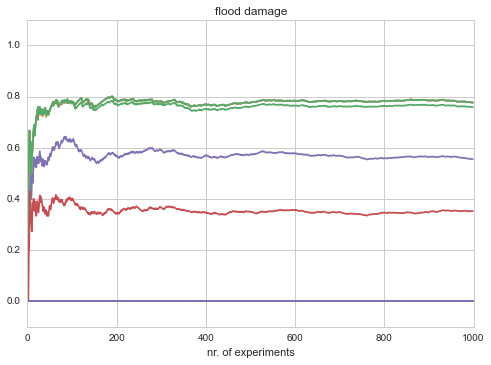

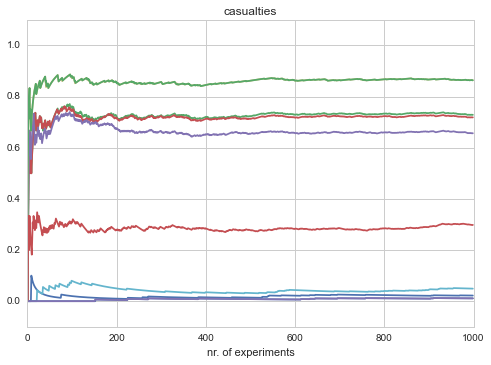

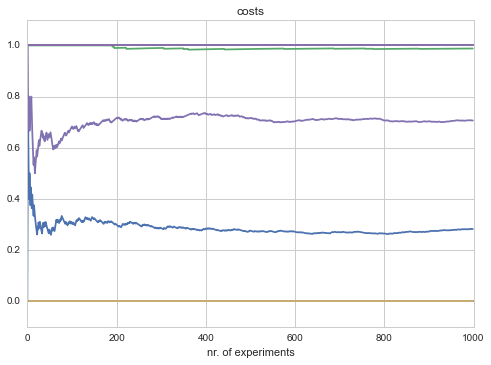

In [4]:
import seaborn as sns

from collections import OrderedDict

sns.set_style('whitegrid')

data = OrderedDict()
data['flood damage'] = flood_damage
data['casualties'] = casualties
data['costs'] = costs

for key, value in data.items():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(key)
    ax.set_xlabel('nr. of experiments')
    ax.set_ylim(ymin=-0.1, ymax=1.1)

    for pathway in pathways:
        value.items
        ax.plot(value[pathway])




## parametrization of the algorithm

Given that this metric is scaled between 0 and 1, we use an epsilon of 0.1




# analysis of optimization results

In [1]:
import cPickle
import seaborn as sns

from deap import creator, base
from expWorkbench.model_ensemble import MINIMIZE

weights = (MINIMIZE, ) * 3
creator.create("Fitness", base.Fitness, weights=weights)
creator.create('Individual', dict, fitness=creator.Fitness)

data = cPickle.load(open(r'./data/obj_func4.cPickle', 'r'))
stats = data[0]

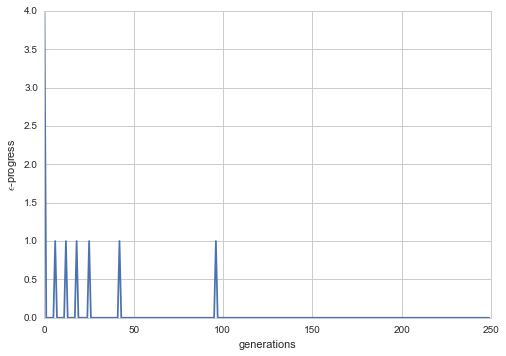

In [2]:
sns.set_style('whitegrid')

fig = plt.figure()
ax = fig.add_subplot(111)

data = np.asarray(stats.change)
ax.plot(data[:,2], label='$\epsilon$-progress')
ax.set_xlabel('generations')
ax.set_ylabel('$\epsilon$-progress')

plt.show()

The algorithm converges quickly. After a 100 generations, no epsilon progress is booked

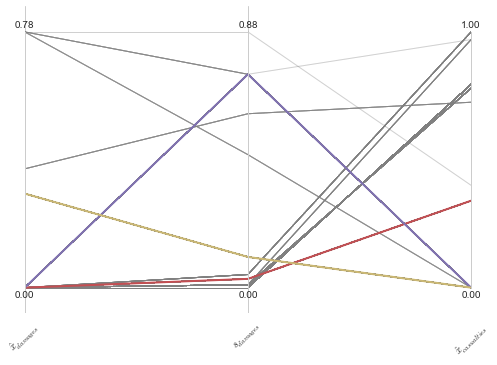

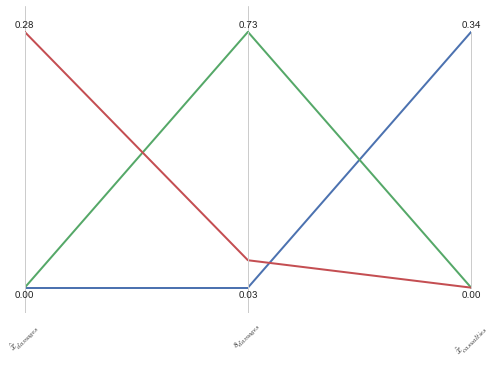

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  

def make_parallel_plot(nr_columns, labels, maxima, minima):

    fig = plt.figure()
    axes = []
    
    # we need one axes less than the shape
    for i in range(1, nr_columns):
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]], rotation=45)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "{:.2f}".format(maxima[i-1]), va="bottom", ha="center")
        ax.text(i, -0.01,"{:.2f}".format(minima[i-1]), va="top", ha="center")
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1])
    ax.text(i+1, 1.01, "{:.2f}".format(maxima[i]), va="bottom", ha="center")
    ax.text(i+1, -0.01,"{:.2f}".format(minima[i]), va="top", ha="center")
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return axes


def parallel_pareto_front(stats_callback, labels, with_tried=True):
    
    def normalize(data, data_to_norm):
        minima = np.min(data, axis=0)
        maxima = np.max(data, axis=0)
        d = maxima - minima
        
        d[d==0] = 1
        
        norm_data = data_to_norm/d - minima/d
        return norm_data, minima, maxima
    

    hof = stats_callback.archive
    tried = stats_callback.stats
    if type(tried)==pd.DataFrame:
        tried = tried.as_matrix()
    
    data_hof = np.zeros((len(hof), len(hof[0].fitness.values)))
    
    for i, entry in enumerate(hof):
        data_hof[i,:] = entry.fitness.values    
    
    if with_tried:
        hof_norm, minima, maxima = normalize(tried, data_hof)
        tried_norm, minima, maxima = normalize(tried, tried)
    else:
        hof_norm, minima, maxima = normalize(data_hof, data_hof)
    
    axes = make_parallel_plot(hof_norm.shape[1], labels, maxima, minima)
    
    if with_tried:
        # visualize tried solution
        for i,j in zip(range(tried_norm.shape[1]-1),range(1,tried_norm.shape[1])):
            ax = axes[i]
            y = tried_norm[:, i:j+1]
            x = np.tile([i+1,j+1], (tried_norm.shape[0], 1))
            ax.plot(x.T, y.T, c='grey', alpha=0.2, lw=1)
    
    # visualize hof
    for i,j in zip(range(hof_norm.shape[1]-1),range(1,hof_norm.shape[1])):
        ax = axes[i]
        y = hof_norm[:, i:j+1]
        x = np.tile([i+1,j+1], (hof_norm.shape[0], 1))
        ax.plot(x.T, y.T, lw=2)

        
obj_labels = ['$\hat{x}_{damages}$', '$s_{damages}$',
              '$\hat{x}_{casualties}$', '$s_{casualties}$',
              '$\hat{x}_{costs}$', '$s_{costs}$',]
parallel_pareto_front(stats, obj_labels)
parallel_pareto_front(stats, obj_labels, with_tried=False)

In [4]:
from __future__ import division 
import matplotlib.ticker as ticker 
import matplotlib.colors as colors 
import matplotlib.cm as cmx
import matplotlib as mpl

def _make_parallel_plot(data, labels):
    '''Helper function for setting up the pathway 
    visualization plot
    
    Parameters
    ----------
    data : 
        ?
    labels : 
        ?
    
    Returns
    -------
    list
        a list of axes that make up the parallel
        coordinate plot
    
    '''
    
    fig = plt.figure()
    axes = []
    alpha = 0.5
    # we need one axes less than the shape
    for i in range(1, data.shape[1]):
        ax = fig.add_subplot(1,data.shape[1]-1,i, ylim=(-0.1,1.1)) 
        axes.append(ax)
        
        ax.set_xlim([i,i+1]) 
        ax.xaxis.set_major_locator(ticker.FixedLocator([i])) 
        ax.xaxis.set_ticklabels([labels[i-1]]) 
        ax.xaxis.set_tick_params(bottom=False, top=False)
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        rect = plt.Rectangle((i, 0), 1, 0.225, facecolor='lightgrey',
                             edgecolor='lightgrey', alpha=alpha)
        ax.add_patch(rect)
        
        rect = plt.Rectangle((i, 0.225), 1, 0.2, facecolor='white',
                             edgecolor='white', alpha=alpha)
        
        rect = plt.Rectangle((i, 0.425), 1, 0.20, facecolor='lightgrey',
                             edgecolor='lightgrey', alpha=alpha)
        ax.add_patch(rect)
                             
        rect = plt.Rectangle((i, 0.625), 1, 0.15, facecolor='white',
                             edgecolor='white', alpha=alpha)
        ax.add_patch(rect)
                             
        rect = plt.Rectangle((i, 0.775), 1, 0.1, facecolor='lightgrey',
                             edgecolor='lightgrey', alpha=alpha)
        ax.add_patch(rect)
                                 
        rect = plt.Rectangle((i, 0.875), 1, 0.125, facecolor='white',
                             edgecolor='white', alpha=alpha)
        ax.add_patch(rect)
    
    # fo the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1])
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label2On=True
    # stack the subplots together
    plt.subplots_adjust(wspace=0) 
    
    return axes


def _normalize(data):
    '''Helper function for normalizing the data'''
    minima = np.array([0,0,0]) 
    maxima = np.array([20,20,20]) 
    d = maxima - minima
    norm_data = data/d - minima/d 
    return norm_data


def visualize_pathways(pathways):
    '''Function for visualizing pathways as a 
    sequence of 3 actions. 
    
    Parameters
    ----------
    pathways : list
        a list of pathways, where each pathway
        is itself a list of names

    
    '''
    labels = ["action 1", "action 2", "action 3"]

    # Used for ranking the pathways on the y-axis
    score =  {'Dike 2nd Q x 1.5': 0,
              'Dike 1:1000 extr.': 1,
              'Dike 1:500 extr.': 2,
              'Dike 1:1000': 3,
              'Dike 1:500 +0.5m': 4,
              'RfR Large Scale' : 5,
              'RfR Medium Scale': 6,
              'RfR Small Scale' : 7,
              'RfR Side channel': 8,
              'DC Mounts': 9,
              'DC Elevated':10,
              'DC Dikes': 11,
              'DC Floating': 12,
              'Coop Small': 13,
              'Coop Medium': 14,
              'Coop Large': 15,
              'Dike Climate dikes': 16,
              'Dike Wave resistant':17,
              'Alarm Late': 18,
              'Alarm Education': 19,
              'Alarm Early': 20,
              }
    ylabels = sorted(score, key=score.get)      
    
    data = np.zeros((len(pathway_names), 3)) 
    for i, pathway in enumerate(pathways):
        pathway = [score[element] for element in pathway]
        data[i,:] = pathway
    
    axes = _make_parallel_plot(data, labels)
    axes[0].yaxis.set_ticks(np.arange(0,1.01, 1/20))
    axes[0].set_yticklabels(ylabels)
    axes[0].yaxis.grid()
    axes[1].yaxis.set_ticks(np.arange(0,1.01, 1/20)) 
    axes[1].set_yticklabels(ylabels)
    
    for tick in axes[1].yaxis.get_major_ticks():
        tick.label2On=True
        tick.label1On=False
    axes[1].yaxis.grid()
    norm_data = _normalize(data)
    
    for i,j in zip(range(data.shape[1]-1),range(1,data.shape[1])): 
        ax = axes[i]
        y = norm_data[:, i:j+1]
        x = np.tile([i+1,j+1], (data.shape[0], 1))

        for k in range(x.shape[0]): 
            ax.plot(x[k, :], y[k, :])




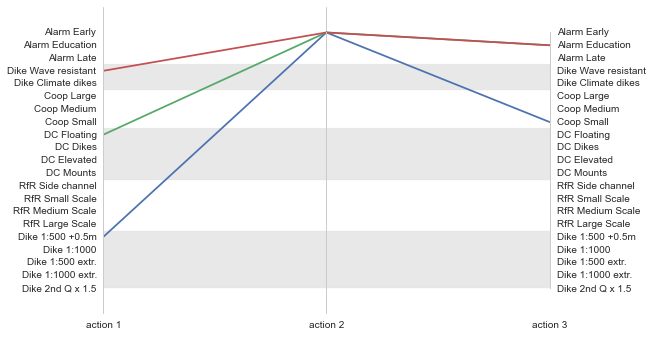

In [5]:
hof = stats.archive
index = ["flood damage", "casualties", "costs"]
lines = []

for entry in hof: 
    line = []
    for key in ['action_1', 'action_2', 'action_3']: 
        line.append(entry[key]['name'])
    lines.append(line)
    scores = [entry.fitness.values[0],
              entry.fitness.values[1],
              entry.fitness.values[2]]

pathway_names = lines
visualize_pathways(pathway_names)
plt.show()